In [1]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch

DEVICE = 'cuda:3'

processor = AutoProcessor.from_pretrained("MINT-SJTU/RoboFAC-7B", trust_remote_code=True, torch_dtype=torch.float16)
model = AutoModelForVision2Seq.from_pretrained("MINT-SJTU/RoboFAC-7B", trust_remote_code=True, torch_dtype=torch.float16).to(DEVICE)

processor.patch_size = model.config.vision_config.patch_size
processor.num_additional_image_tokens = getattr(model.config.vision_config, "num_additional_image_tokens", 0)
# processor.vision_feature_select_strategy = model.config.vision_config.vision_feature_select_strategy

/home/user10_3/.conda/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Loading checkpoint shards: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]


In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

DEVICE = 'cuda:3'


# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="float16", device_map=DEVICE
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

processor.patch_size = model.config.vision_config.patch_size
processor.num_additional_image_tokens = getattr(model.config.vision_config, "num_additional_image_tokens", 0)
# processor.vision_feature_select_strategy = model.config.vision_config.vision_feature_select_strategy

/home/user10_3/.conda/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading checkpoint shards: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [ ]:
inputs = processor(images=[...], text="Why did the robot fail?", return_tensors="pt").to("cuda:1")
outputs = model.generate(**inputs)
print(processor.batch_decode(outputs, skip_special_tokens=True))

In [2]:
import torch
from moviepy import ImageSequenceClip
from IPython.display import HTML
from base64 import b64encode
import tempfile
import os

def tensors_to_video_jupyter(tensors: list[torch.Tensor], fps: int = 30):
    frames = [tensor.squeeze(0).cpu().numpy().astype('uint8') for tensor in tensors]

    clip = ImageSequenceClip(frames, fps=fps)

    with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as tmpfile:
        temp_filename = tmpfile.name
        clip.write_videofile(temp_filename, codec="libx264", audio=False)

    with open(temp_filename, "rb") as f:
        video_data = f.read()
    os.remove(temp_filename)

    encoded = b64encode(video_data).decode('utf-8')
    video_html = f'''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    '''
    return HTML(video_html)

In [3]:
import torch.nn as nn
import numpy as np
from torch.distributions.normal import Normal

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class NatureCNN(nn.Module):
    def __init__(self, sample_obs):
        super().__init__()

        extractors = {}

        self.out_features = 0
        feature_size = 256
        in_channels=sample_obs["rgb"].shape[-1]
        image_size=(sample_obs["rgb"].shape[1], sample_obs["rgb"].shape[2])


        # here we use a NatureCNN architecture to process images, but any architecture is permissble here
        cnn = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=32,
                kernel_size=8,
                stride=4,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0
            ),
            nn.ReLU(),
            nn.Flatten(),
        )

        # to easily figure out the dimensions after flattening, we pass a test tensor
        with torch.no_grad():
            n_flatten = cnn(sample_obs["rgb"].float().permute(0,3,1,2).cpu()).shape[1]
            fc = nn.Sequential(nn.Linear(n_flatten, feature_size), nn.ReLU())
        extractors["rgb"] = nn.Sequential(cnn, fc)
        self.out_features += feature_size

        if "state" in sample_obs:
            # for state data we simply pass it through a single linear layer
            state_size = sample_obs["state"].shape[-1]
            extractors["state"] = nn.Linear(state_size, 256)
            self.out_features += 256

        self.extractors = nn.ModuleDict(extractors)

    def forward(self, observations) -> torch.Tensor:
        # import ipdb; ipdb.set_trace()
        encoded_tensor_list = []
        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            obs = observations[key]
            if key == "rgb":
                obs = obs.float().permute(0,3,1,2)
                obs = obs / 255
            encoded_tensor_list.append(extractor(obs))
        return torch.cat(encoded_tensor_list, dim=1)

class PPO_rgb(nn.Module):
    def __init__(self, envs, sample_obs):
        super().__init__()
        self.feature_net = NatureCNN(sample_obs=sample_obs)
        # latent_size = np.array(envs.unwrapped.single_observation_space.shape).prod()
        latent_size = self.feature_net.out_features
        self.critic = nn.Sequential(
            layer_init(nn.Linear(latent_size, 512)),
            nn.ReLU(inplace=True),
            layer_init(nn.Linear(512, 1)),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(latent_size, 512)),
            nn.ReLU(inplace=True),
            layer_init(nn.Linear(512, np.prod(envs.unwrapped.single_action_space.shape)), std=0.01*np.sqrt(2)),
        )
        self.actor_logstd = nn.Parameter(torch.ones(1, np.prod(envs.unwrapped.single_action_space.shape)) * -0.5)
    def get_features(self, x):
        return self.feature_net(x)
    def get_value(self, x):
        x = self.feature_net(x)
        return self.critic(x)
    def get_action(self, x, deterministic=False):
        x = self.feature_net(x)
        action_mean = self.actor_mean(x)
        if deterministic:
            return action_mean
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        return probs.sample()
    def get_action_and_value(self, x, action=None):
        # import ipdb; ipdb.set_trace()
        x = self.feature_net(x)
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)
    

class PPO(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 1)),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, np.prod(envs.single_action_space.shape)), std=0.01*np.sqrt(2)),
        )
        self.actor_logstd = nn.Parameter(torch.ones(1, np.prod(envs.single_action_space.shape)) * -0.5)

    def get_value(self, x):
        return self.critic(x)
    def get_action(self, x, deterministic=False):
        action_mean = self.actor_mean(x)
        if deterministic:
            return action_mean
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        return probs.sample()
    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

без РРО

In [7]:
from gymnasium import spaces
import gymnasium as gym
import mani_skill


class ManiSkillCameraWrapper(gym.ObservationWrapper):
    def __init__(self, env: gym.Env):
        super().__init__(env)

        base_cam_space = env.observation_space.spaces['sensor_data'].spaces['base_camera'].spaces['rgb']
        self.observation_space = spaces.Dict({
            'rgb': base_cam_space,
        })

    def observation(self, obs: dict) -> dict:
        new_obs = {
            'rgb': obs['sensor_data']['base_camera']['rgb'],
        }
        return new_obs


sensor_configs = {"width": 512, "height": 512}

env = gym.make(
    "PegInsertionSide-v1",
    obs_mode="rgb",
    num_envs=1, # if num_envs > 1, GPU simulation backend is used.
    sensor_configs = sensor_configs,
    render_mode = 'rgb_array',
    # sensor_configs=dict(shader_pack="default"),
    # human_render_camera_configs=dict(shader_pack="default"),
    # viewer_camera_configs=dict(shader_pack="default"),

)
# instruction = env.unwrapped.get_language_instruction()
# print("instruction:", instruction[0])

prompts = ['In the video, the robotic arm executes a task, was it successful?',
           'From the video of the robotic arm failing during the task, provide high-level corrective commands to guide it to recover and finish the task.',
           'This is a video of a robotic arm performing a task, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully.'
           ]

env = ManiSkillCameraWrapper(env)
obs, _ = env.reset()
# returns language instruction for each parallel env
# instruction = ['Pull the cube to the red and white target.']#env.unwrapped.get_language_instruction()
# print("instruction:", instruction[0])

use_vlm = True
obs_list = []
steps = 30
img = None
for i in range(steps):
    # obs_list.append(obs['rgb'].clone())
    
    img = env.render()
    obs_list.append(img.clone())
    action = env.action_space.sample() # replace this with your policy inference
    obs, reward, terminated, truncated, info = env.step(action)
    
    if truncated.any() or terminated.any():
        break
    # import matplotlib.pyplot as plt
    # plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())
    # import time; time.sleep(2)

if use_vlm:
    for prompt in prompts:
        from torchvision.transforms.functional import to_pil_image

        # Преобразуем каждый тензор в PIL.Image
        obs_list_pil = [to_pil_image(img_tensor[0]) for img_tensor in obs_list]

        messages = [
                {
                "role": "user",
                "content": [
                    *[{"type": "image", "image": img} for img in obs_list],
                    {"type": "text", "text": prompt}
                ],
                }
        ]
        print(f'prompt: {prompt}')
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            images=obs_list,
            padding=True,
            return_tensors="pt",
        ).to("cuda")
        output = processor.batch_decode(model.generate(**inputs, max_new_tokens=2048), skip_special_tokens=True)[0]
        print(f'{output}\n')
print("Episode Info", info)

ValueError: pic should not have > 4 channels. Got 512 channels.

In [6]:
obs_list[0][0].shape

torch.Size([512, 512, 3])

In [39]:
tensors_to_video_jupyter(obs_list, fps = 5)

MoviePy - Building video /tmp/tmpua8vckv_.mp4.
MoviePy - Writing video /tmp/tmpua8vckv_.mp4



MoviePy - Done !
MoviePy - video ready /tmp/tmpua8vckv_.mp4


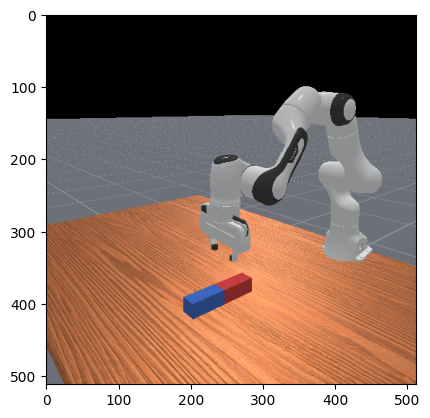

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.array(img.detach().cpu()[0]))

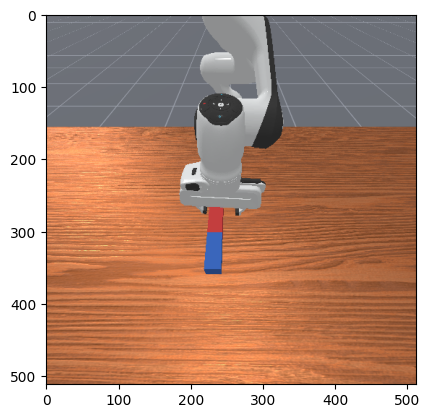

In [11]:
plt.imshow(np.array(obs_list[0].detach().cpu()[0]))

с РРО

In [17]:
from gymnasium import spaces
import gymnasium as gym
import mani_skill


sensor_configs = {"width": 512, "height": 512}

env = gym.make(
  "PegInsertionSide-v1",
  obs_mode="rgb",
  num_envs=1, # if num_envs > 1, GPU simulation backend is used.
  sensor_configs = sensor_configs,
  render_mode = 'rgb_array',

)
partial_reset = True
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper, FlattenRGBDObservationWrapper
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
env = FlattenRGBDObservationWrapper(env, rgb=True, depth=False, state=True)
if isinstance(env.action_space, gym.spaces.Dict):
    env = FlattenActionSpaceWrapper(env)
env = ManiSkillVectorEnv(env, 1, ignore_terminations=not partial_reset, record_metrics=True)

# instruction = env.unwrapped.get_language_instruction()
# print("instruction:", instruction[0])

prompts = ['In the video, the robotic arm executes a task, was it successful?',
        #    'From the video of the robotic arm failing during the task, provide high-level corrective commands to guide it to recover and finish the task.',
           'This is a video of a robotic arm performing a task, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully.',
           'This is a video of a robotic arm performing a task, please explain in detail the reason for the task failure.'
           ]

# env = ManiSkillCameraWrapper(env)
obs, _ = env.reset()
# from ..ManiSkill.examples.baselines.ppo.ppo_rgb import Agent 
agent = PPO_rgb(env, sample_obs=obs)
agent = agent.to(DEVICE)
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/PegInsertionSide-v1__ppo__1__1752050019/ckpt_1226.pt'))
agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/PegInsertionSide-v1__ppo_rgb__1__1752039752/ckpt_601.pt'))
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/LiftPegUpright__ppo_rgb__1__1751971812/final_ckpt.pt'))
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/LiftPegUpright__ppo_rgb__1__1751971812/ckpt_301.pt'))
# agent.load_state_dict(torch.load('/home/user10/ManiSkill/examples/baselines/ppo/runs/LiftPegUpright-v1__ppo_rgb__1__1751570673/final_ckpt.pt'))
# agent.load_state_dict(torch.load('/home/user10/ManiSkill/examples/baselines/ppo/runs/StackCube-v1__ppo_rgb__1__1751570406/final_ckpt.pt'))
# returns language instruction for each parallel env
# instruction = ['Pull the cube to the red and white target.']#env.unwrapped.get_language_instruction()
# print("instruction:", instruction[0])

agent.eval()
use_vlm = True
obs_list = []
steps = 40
img = None
for i in range(steps):
    # obs_list.append(obs['rgb'].clone())
    
    img = env.render()
    obs_list.append(img.clone())
    # action = env.action_space.sample() # replace this with your policy inference
    obs = {k: v.to(DEVICE) for k, v in obs.items()}
    action, _, _, _ = agent.get_action_and_value(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    
    if truncated.any() or terminated.any():
        break
    # import matplotlib.pyplot as plt
    # plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())
    # import time; time.sleep(2)

if use_vlm:
    for prompt in prompts:
        messages = [
                {
                "role": "user",
                "content": [
                    *[{"type": "image", "image": img[0].permute(2,0,1)} for img in obs_list],
                    {"type": "text", "text": prompt}
                ],
                }
        ]
        print(f'prompt: {prompt}')
        print(f"img shape: {img.shape}")
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            images=obs_list,
            padding=True,
            return_tensors="pt",
        ).to(DEVICE)
        
        output = processor.batch_decode(model.generate(**inputs, max_new_tokens=2048), skip_special_tokens=True)[0]
        print(f'{output}\n')
print("Episode Info", info)

prompt: In the video, the robotic arm executes a task, was it successful?
img shape: torch.Size([1, 512, 512, 3])


system
You are a helpful assistant.
user
In the video, the robotic arm executes a task, was it successful?
assistant
No.

prompt: This is a video of a robotic arm performing a task, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully.
img shape: torch.Size([1, 512, 512, 3])
system
You are a helpful assistant.
user
This is a video of a robotic arm performing a task, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully.
assistant
Move the robot arm slightly backward to create space, then adjust the arm to the left and lower it carefully to align with the peg on the table. Finally, extend the gripper forward to reach the peg accurately.

prompt: This is a video of a robotic arm performing a task, please explain in detail the reason for the task failure.
img shape: torch.Size([1, 512, 512, 3])
system
You are a hel

In [18]:
tensors_to_video_jupyter(obs_list, fps = 5)

MoviePy - Building video /tmp/tmpkvmz1rpu.mp4.
MoviePy - Writing video /tmp/tmpkvmz1rpu.mp4



MoviePy - Done !
MoviePy - video ready /tmp/tmpkvmz1rpu.mp4


In [29]:
obs_list[0].shape

torch.Size([1, 512, 512, 3])

In [30]:
obs_list.__len__()

19

In [31]:
from gymnasium import spaces
import gymnasium as gym
from qwen_vl_utils import process_vision_info
import mani_skill


sensor_configs = {"width": 512, "height": 512}
task = 'LiftPegUpright'
env = gym.make(
  f"{task}",
  obs_mode="rgb",
  num_envs=1, # if num_envs > 1, GPU simulation backend is used.
  sensor_configs = sensor_configs,
  render_mode = 'rgb_array',

)
partial_reset = True
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper, FlattenRGBDObservationWrapper
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
env = FlattenRGBDObservationWrapper(env, rgb=True, depth=False, state=True)
if isinstance(env.action_space, gym.spaces.Dict):
    env = FlattenActionSpaceWrapper(env)
env = ManiSkillVectorEnv(env, 1, ignore_terminations=not partial_reset, record_metrics=True)

# instruction = env.unwrapped.get_language_instruction()
# print("instruction:", instruction[0])

prompts_qwen = [f'In the video, the robotic arm executes a task ({task}), was it successful?',
        #    f'From the video of the robotic arm failing during the task ({task}), provide high-level corrective commands to guide it to recover and finish the task. (Your answer should be a detailed textual suggestion of about two to three sentences.)',
        #    f'This is a video of a robotic arm performing a task ({task}), an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully. (Your answer should describe which direction (relative to the robot arm) and how much the robot arm should move to recover from the failure.)")',
        #    f'This is a video of a robotic arm performing a task ({task}), please explain in detail the reason for the task failure. (Your answer should be a detailed textual description of about two to three sentences.)'
           ]
prompts = ['In the video, the robotic arm executes a task, was it successful?',
           'From the video of the robotic arm failing during the task, provide high-level corrective commands to guide it to recover and finish the task.',
           'This is a video of a robotic arm performing a task, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully.',
           'This is a video of a robotic arm performing a task, please explain in detail the reason for the task failure.'
           ]

# env = ManiSkillCameraWrapper(env)
obs, _ = env.reset()
# from ..ManiSkill.examples.baselines.ppo.ppo_rgb import Agent 
agent = PPO_rgb(env, sample_obs=obs)
# agent = PPO(env)
agent = agent.to(DEVICE)
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/StackCube-v1__ppo_rgb__1__1752076784/ckpt_151.pt'))
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/PegInsertionSide-v1__ppo__1__1752050019/ckpt_1226.pt'))
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/PegInsertionSide-v1__ppo_rgb__1__1752039752/ckpt_601.pt'))
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/LiftPegUpright__ppo_rgb__1__1751971812/final_ckpt.pt'))
agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/LiftPegUpright__ppo_rgb__1__1751971812/ckpt_676.pt'))
# agent.load_state_dict(torch.load('/home/user10/ManiSkill/examples/baselines/ppo/runs/LiftPegUpright-v1__ppo_rgb__1__1751570673/final_ckpt.pt'))
# agent.load_state_dict(torch.load('/home/user10/ManiSkill/examples/baselines/ppo/runs/StackCube-v1__ppo_rgb__1__1751570406/final_ckpt.pt'))
# agent.load_state_dict(torch.load('/home/user10_3/ManiSkill/examples/baselines/ppo/runs/PickCube-v1__ppo_rgb__1__1752068048/ckpt_401.pt'))

# returns language instruction for each parallel env
# instruction = ['Pull the cube to the red and white target.']#env.unwrapped.get_language_instruction()
# print("instruction:", instruction[0])

agent.eval()
use_vlm = True
obs_list = []
steps = 40
img = None
for i in range(steps):
    # obs_list.append(obs['rgb'].clone())
    
    img = env.render()
    obs_list.append(img.clone())
    # action = env.action_space.sample() # replace this with your policy inference
    obs = {k: v.to(DEVICE) for k, v in obs.items()}
    action, _, _, _ = agent.get_action_and_value(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    
    if truncated.any() or terminated.any():
        break
    # import matplotlib.pyplot as plt
    # plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())
    # import time; time.sleep(2)

from torchvision.transforms.functional import to_pil_image

# Преобразуем obs_list (тензоры) → PIL изображения
obs_list_pil = []
for img in obs_list:
    img_np = img[0].cpu()  # [512, 512, 3]
    if img_np.max() > 1.0:
        img_np = img_np / 255.0
    img_pil = to_pil_image(img_np.permute(2, 0, 1))  # → (3, H, W)
    obs_list_pil.append(img_pil)

outputs = []
if use_vlm:
    for prompt in prompts_qwen:
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "video",
                        "video": obs_list_pil,
                        
                    },
                    {"type": "text", "text": prompt},
                ],
            }
        ]

        # Preparation for inference
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True)
        fps = video_kwargs.get("fps", 1.0)  
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            # fps=1.0,
            padding=True,
            return_tensors="pt",
            **video_kwargs,
        )
        inputs = inputs.to(DEVICE)
        obs_list
        output = processor.batch_decode(model.generate(**inputs, max_new_tokens=2048), skip_special_tokens=True)[0]
        print(f'{output}\n')
        outputs.append(output)
print("Episode Info", info)

system
You are a helpful assistant.
user
In the video, the robotic arm executes a task (LiftPegUpright), was it successful?
assistant
The robotic arm in the video appears to be attempting to lift and upright a red and blue block. The sequence of images shows the arm approaching the block, making contact with it, and then lifting it slightly off the surface. However, the block is not fully upright; instead, it remains tilted at an angle.

Given this observation, it seems that the task of lifting the block upright was not entirely successful. The block is partially lifted but not positioned in a stable upright position as intended by the "LiftPegUpright" task.

Episode Info {'elapsed_steps': tensor([40], dtype=torch.int32), 'success': tensor([False]), 'episode': {'success_once': tensor([False]), 'return': tensor([20.1602]), 'episode_len': tensor([40], dtype=torch.int32), 'reward': tensor([0.5040])}}


In [14]:
print(outputs[1])

system
You are a helpful assistant.
user
From the video of the robotic arm failing during the task (LiftPegUpright), provide high-level corrective commands to guide it to recover and finish the task. (Your answer should be a detailed textual suggestion of about two to three sentences.)
assistant
To correct the robotic arm's failure, you can instruct it to adjust its grip on the object by slightly rotating or repositioning the gripper to ensure a secure hold. Once the grip is adjusted, gently lift the object with a controlled upward motion, ensuring that the object remains stable and upright throughout the process. If necessary, you can also use a slower speed setting to prevent any accidental tipping or dropping of the object.


In [32]:
tensors_to_video_jupyter(obs_list, fps = 5)

MoviePy - Building video /tmp/tmpyiriy6av.mp4.
MoviePy - Writing video /tmp/tmpyiriy6av.mp4



MoviePy - Done !
MoviePy - video ready /tmp/tmpyiriy6av.mp4


In [15]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 1 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgb")

In [ ]:
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
obs_list2 = []
for i in range(50):
    # print(i)
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    obs_list2.append(obs)
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
    
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['base_camera'])
dict_keys(['rgb'])
torch.Size([1, 128, 128, 3])


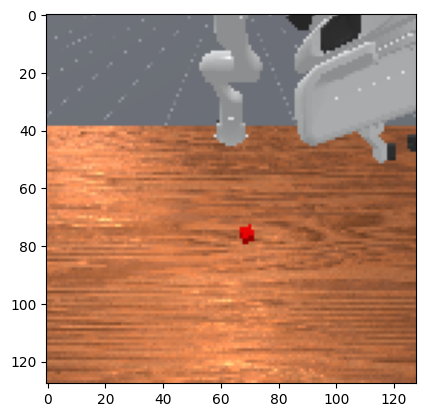

In [23]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs_list2[49]['sensor_data']['base_camera']['rgb'][0].cpu().numpy())

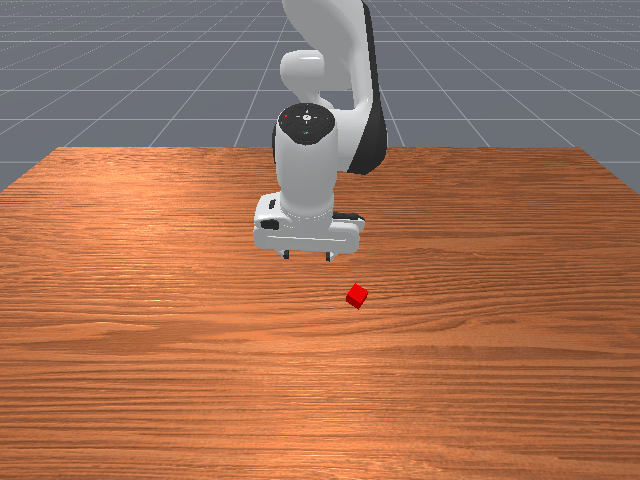

In [11]:
from PIL import Image

Image.fromarray(obs_list[0][0].cpu().numpy())

In [ ]:
obs_list[0]

50

In [13]:
obs_list[1].shape

torch.Size([1, 480, 640, 3])